## Experiment Setup

###  Random seed / Colab / CUDA related

In [1]:
import time
import datetime
import os
import sys
import itertools

# Use Google Colab
use_colab = True

# Is this notebook running on Colab?
# If so, then google.colab package (github.com/googlecolab/colabtools)
# should be available in this environment

# Previous version used importlib, but we could do the same thing with
# just attempting to import google.colab
try:
    from google.colab import drive
    colab_available = True
except:
    colab_available = False

if use_colab and colab_available:
    drive.mount('/content/drive')
    
    # If there's a package I need to install separately, do it here
    !pip install pyro-ppl

    # cd to the appropriate working directory under my Google Drive
    %cd 'drive/My Drive/Colab Notebooks/bayesian-dl-experiments'
    
    # List the directory contents
    !ls

# IPython reloading magic
%load_ext autoreload
%autoreload 2

# Random seeds
# Based on https://pytorch.org/docs/stable/notes/randomness.html
random_seed = 682

### Third party libraries (NumPy, PyTorch, Pyro)

In [2]:
# Third party libraries import
import numpy as np
import torch
import pyro
import matplotlib.pyplot as plt

# Print version information
print("Python Version: " + sys.version)
print("NumPy Version: " + np.__version__)
print("PyTorch Version: " + torch.__version__)
print("Pyro Version: " + pyro.__version__)

Python Version: 3.8.0 (v3.8.0:fa919fdf25, Oct 14 2019, 10:23:27) 
[Clang 6.0 (clang-600.0.57)]
NumPy Version: 1.17.4
PyTorch Version: 1.4.0a0+328ec54
Pyro Version: 1.0.0


In [3]:
# More imports...
from torch import nn, optim
from torch.utils.data import random_split, DataLoader, RandomSampler
import torchvision
import torchvision.transforms as transforms
from pyro.infer import SVI, Trace_ELBO, HMC, MCMC

# Import model and dataset classes from ronald_bdl
from ronald_bdl import models, datasets

# pyplot setting
%matplotlib inline

# torch.device / CUDA Setup
use_cuda = True

if use_cuda and torch.cuda.is_available():
    torch_device = torch.device('cuda')

    torch.backends.cudnn.deterministic = True
    # Disable 'benchmark' mode
    # Note: https://discuss.pytorch.org/t/what-does-torch-backends-cudnn-benchmark-do/5936
    torch.backends.cudnn.benchmark = False
    use_pin_memory = True # Faster Host to GPU copies with page-locked memory

    # CUDA libraries version information
    print("CUDA Version: " + str(torch.version.cuda))
    print("cuDNN Version: " + str(torch.backends.cudnn.version()))
    print("CUDA Device Name: " + str(torch.cuda.get_device_name()))
    print("CUDA Capabilities: "+ str(torch.cuda.get_device_capability()))
else:
    torch_device = torch.device('cpu')
    use_pin_memory = False

### Toy dataset settings

In [4]:
"""
Toy dataset generation based on the experiment from 
the Probabilstic Backpropagation paper (Hernandez-Lobato & Adams, 2015)
"""

# Random seed for toy dataset
dataset_toy_random_seed = 691

# Toy dataset size
dataset_toy_size = 20

# Toy dataset x distribution (uniform) parameters
dataset_toy_x_low = -4
dataset_toy_x_high = 4

# Toy dataset y distribution (normal with noise)
dataset_toy_y_mean = 0
dataset_toy_y_std = 9

### MC dropout parameters

In [5]:
"""
MC Dropout related
"""

# Dropout rate
dropout_rate = 0.1

# Regularization strengths
reg_strength = 0.05

# Epochs
n_epochs = 4000

# Optimizer learning rate
learning_rate = 0.001

# Loss function type
loss_function_type = 'mse_loss'

# Number of test predictions (for each data point)
n_predictions = 1000

### Directory path to save results

In [6]:
# Test start time
test_start_time = datetime.datetime.today().strftime('%Y%m%d%H%M')

# Directory to store the results for this experiment
test_results_path = os.path.join(
    './test_results',
    'comparison_toy',
    (
        test_start_time 
        + '_' + str(n_epochs) 
        + '_' + str(dropout_rate) 
        + '_' + str(reg_strength) 
        + '_' + str(loss_function_type) 
        + '_' + str(n_predictions))
)

# Create the directory if it doesn't exist
os.makedirs(test_results_path, exist_ok=True)

## Prepare data

### Get the data as a torch Dataset object

In [7]:
dataset = datasets.ToyDatasets(
    random_seed=dataset_toy_random_seed,
    n_samples=dataset_toy_size,
    x_low=dataset_toy_x_low,
    x_high=dataset_toy_x_high,
    y_mean=dataset_toy_y_mean,
    y_std=dataset_toy_y_std,
)

# Get the test data
X_test = torch.linspace(dataset_toy_x_low, dataset_toy_x_high, 100).reshape(100, 1)

# Send it to the memory of the device to be used for training
X_test = X_test.to(torch_device)

# Save a copy at CPU for plotting
X_test_cpu = X_test.cpu()

# Print the size of the training set
print("dataset size = " + str((len(dataset), dataset.n_features)))

dataset size = (20, 1)


## Declare models

In [8]:
uncertainty_methods = {}

# MC (Bernoulli) dropout
do_mc_dropout = True

if do_mc_dropout:
    uncertainty_methods['mc_dropout'] = models.FCNet(
        input_dim=dataset.n_features, 
        output_dim=dataset.n_targets,
        hidden_dim=100,
        n_hidden=0,
        dropout_rate=dropout_rate,
        dropout_type='bernoulli',
    )

# Vanilla Variational Inference
do_vi = False

if do_vi:
    uncertainty_methods['vi'] = models.FCNetPyro(
        input_dim=dataset.n_features, 
        output_dim=dataset.n_targets,
        hidden_dim=100,
        n_hidden=0,
        torch_device=torch_device,
    )

# HMC
do_hmc = False

if do_hmc:
    uncertainty_methods['hmc'] = models.FCNetPyro(
        input_dim=dataset.n_features, 
        output_dim=dataset.n_targets,
        hidden_dim=100,
        n_hidden=0,
        torch_device=torch_device,
    )

## Train the models

### Train/test the model

In [9]:
for key, network in uncertainty_methods.items():
    # Reset the random number generator for each method (to produce identical results)
    torch.manual_seed(random_seed)
    np.random.seed(random_seed)
    pyro.set_rng_seed(random_seed)
    
    # Print the method name
    print("Now running " + str(key))
    
    # Send the whole model to the selected torch.device
    network.to(torch_device)

    # Print the network structure
    print(network)
    print()

    # Initialize training data loader
    train_loader = DataLoader(dataset, batch_size=128)
    
    """
    Optimizer Setup
    """

    if isinstance(network, models.FCNet):
        # Adam optimizer
        # https://pytorch.org/docs/stable/optim.html?highlight=adam#torch.optim.Adam
        # NOTE: Need to set L2 regularization from here
        optimizer = torch.optim.Adam(
            network.parameters(),
            lr=learning_rate,
            weight_decay=reg_strength, # L2 regularization
        )

        # Mean Squared Error for loss function to minimize
        objective = torch.nn.MSELoss()

    elif isinstance(network, models.FCNetPyro):
        # Clear everything in Pyro parameter storage
        # Looks like this parameter store would be globally shared across
        # models in the same Python instance.
        pyro.clear_param_store()

        # Force all the PyTorch tensors to be CUDA tensors if available
        if use_cuda and torch.cuda.is_available():
            torch.set_default_tensor_type(torch.cuda.FloatTensor)

        # Different optimizers for VI and HMC
        if key == 'vi':
            optimizer = pyro.optim.Adam({"lr": 0.01})
            svi = SVI(network, network.guide, optimizer, loss=Trace_ELBO())
        elif key == 'hmc':
            kernel = HMC(network)
            mcmc = MCMC(kernel, num_samples=10000)

    """
    Training
    """

    # Model to train mode
    network.train()

    # Record training start time (for this method)
    tic = time.time()
    
    if key == 'hmc':
        # to() actually returns new Tensor; need to replace with that return
        dataset.data_x = dataset.data_x.to(torch_device)

        dataset.data_y = dataset.data_y.to(torch_device)

        mcmc.run(dataset.data_x, dataset.data_y)
    else:
        for epoch in range(n_epochs): # loop over the dataset multiple times

            for i, data in enumerate(train_loader):
                # get the inputs; data is a list of [inputs, labels]
                inputs, targets = data

                # Store the batch to torch_device's memory
                # to() actually returns new Tensor; need to replace with that return
                inputs = inputs.to(torch_device)
                targets = targets.to(torch_device)

                if isinstance(network, models.FCNet):
                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward + backward + optimize
                    outputs = network(inputs)

                    total_loss = objective(outputs, targets)

                    total_loss.backward()

                    optimizer.step()

                elif isinstance(network, models.FCNetPyro):
                    pyro.clear_param_store()
                    # calculate the loss and take a gradient step
                    total_loss = svi.step(inputs, targets)

            if epoch % 100 == 0:
                print("[iteration %04d] loss: %.4f" % (epoch + 1, total_loss))
            
    # Record training end time
    toc = time.time()

    # Report the final loss
    print("final loss = " + str(total_loss))            

    # Report the total training time
    print("training time = " + str(toc - tic) + " seconds")
    
    print()

Now running mc_dropout
FCNet(
  (input): ModuleDict(
    (dropout): Dropout(p=0.1, inplace=False)
    (linear): Linear(in_features=1, out_features=100, bias=True)
    (relu): ReLU()
  )
  (output): ModuleDict(
    (dropout): Dropout(p=0.1, inplace=False)
    (linear): Linear(in_features=100, out_features=1, bias=True)
  )
)

[iteration 0001] loss: 606.2858
[iteration 0101] loss: 367.0081
[iteration 0201] loss: 246.5165
[iteration 0301] loss: 165.5298
[iteration 0401] loss: 224.9545
[iteration 0501] loss: 165.7881
[iteration 0601] loss: 160.3635
[iteration 0701] loss: 158.9023
[iteration 0801] loss: 164.2243
[iteration 0901] loss: 156.9699
[iteration 1001] loss: 171.1219
[iteration 1101] loss: 123.2200
[iteration 1201] loss: 163.2231
[iteration 1301] loss: 252.7004
[iteration 1401] loss: 116.8365
[iteration 1501] loss: 124.8354
[iteration 1601] loss: 168.8555
[iteration 1701] loss: 124.4260
[iteration 1801] loss: 116.5723
[iteration 1901] loss: 90.5095
[iteration 2001] loss: 101.1373
[i

## Plot the results

testing time = 0.41744470596313477 seconds

Mean = tensor([-45.1590, -44.6873, -42.7316, -40.3454, -38.4651, -36.9634, -36.4941,
        -34.9670, -32.8594, -31.3073, -30.4483, -28.7616, -26.7215, -25.4290,
        -23.8092, -22.5536, -20.9463, -19.2538, -17.5880, -16.3533, -14.8251,
        -13.2607, -11.3806, -10.0781,  -8.7344,  -7.0500,  -5.6283,  -4.0356,
         -3.6453,  -3.3887,  -3.0686,  -2.7749,  -2.4762,  -2.2066,  -1.8675,
         -1.5815,  -1.3667,  -1.0701,  -0.8476,  -0.6649,  -0.4660,  -0.2691,
         -0.1031,   0.0651,   0.2398,   0.4278,   0.6242,   0.8047,   0.9807,
          1.1666,   1.3432,   1.4402,   1.5255,   1.6045,   1.6622,   1.7495,
          1.8055,   1.8706,   1.8659,   1.9335,   1.9726,   2.0887,   2.1272,
          2.1306,   2.2397,   2.2394,   2.3265,   2.3610,   2.5279,   3.1484,
          3.8049,   4.5047,   5.1783,   5.8552,   6.4768,   7.2432,   7.7630,
          8.5349,   9.7072,  11.0233,  12.5675,  14.2423,  16.1339,  17.7456,
         19.4

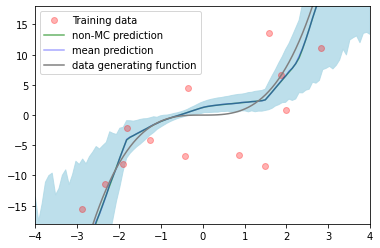

In [10]:
for key, network in uncertainty_methods.items():

    """
    Testing
    """

    # Model to eval mode
    network.eval()

    # Record testing start time (for this split)
    tic_testing = time.time()
    
    predictions_non_mc = network(X_test)

    predictions, mean, var, metrics = network.predict_dist(X_test, n_predictions)
    
    # Record testing end time
    toc_testing = time.time()
    
    # Report the total testing time
    print("testing time = " + str(toc_testing - tic_testing) + " seconds")

    # These can now be stored in CPU memory for plotting
    predictions_non_mc = predictions_non_mc.cpu()
    predictions = predictions.cpu()
    mean = mean.cpu()
    var = var.cpu()
    
    """
    Print results
    """

    print()
    print("Mean = " + str(mean.flatten()))
    print("Variance = " + str(var.flatten()))
    
    # store additional metrics
    if len(metrics) > 0:
        for key, value in metrics.items():
            print(str(key) + " = " + str(value))
        print()
             
    # Plot the uncertainty measured by each methods
    plt.figure()
    
    # Fix the scales of x-axis and y-axis
    plt.xlim(dataset_toy_x_low, dataset_toy_x_high)
    plt.ylim(dataset_toy_y_mean-2*dataset_toy_y_std, dataset_toy_y_mean+2*dataset_toy_y_std)

    # Distributions around the predictions
    plt.fill_between(
        X_test_cpu.flatten(), 
        (mean.detach().numpy() - 2*torch.sqrt(var).detach().numpy()).flatten(),
        (mean.detach().numpy() + 2*torch.sqrt(var).detach().numpy()).flatten(),
        color='lightblue', alpha=0.8)

    # Train data
    plt.plot(dataset.data_x.cpu(), dataset.data_y.cpu(), 'or', label='Training data', alpha=0.3)

    # Non-MC prediction
    plt.plot(X_test_cpu, predictions_non_mc.detach().numpy(), 'green', label='non-MC prediction', alpha=0.6)    
    
    # MC prediction
    plt.plot(X_test_cpu, mean.detach().numpy(), 'blue', label='mean prediction', alpha=0.35)
    
    # Original data generating function without noise
    plt.plot(X_test_cpu, X_test_cpu ** 3, 'gray', label='data generating function')    
    
    plt.legend()
    
    plt.savefig(os.path.join(test_results_path, str(key) + '.png'), dpi=600)
    
    plt.show()